Dataset loaded successfully!
Dataset shape: (19761, 17)
=== DATASET OVERVIEW ===
Features: 16
Samples: 19761
Missing values: 0
Using 16 features for modeling
Feature matrix shape: (19761, 16)
Target vector shape: (19761,)
=== TARGET DISTRIBUTION ===
Label distribution:
  False Positive (0): 6311 samples (31.9%)
  Candidate (1): 7413 samples (37.5%)
  Confirmed Planet (2): 6015 samples (30.4%)
  Class 3 (3): 22 samples (0.1%)


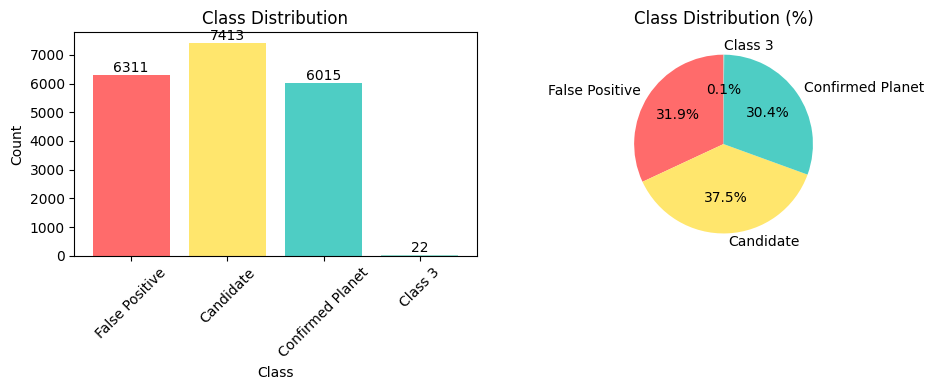

=== DATA SPLITTING ===
Training set: 15808 samples
Testing set: 3953 samples
Training set class distribution:
label
0    5048
1    5930
2    4812
3      18
Name: count, dtype: int64
Testing set class distribution:
label
0    1263
1    1483
2    1203
3       4
Name: count, dtype: int64
=== FEATURE SCALING ===
Feature scaling completed!
Training data shape after scaling: (15808, 16)
Testing data shape after scaling: (3953, 16)
Scaled training data statistics:
               PC1           PC2           PC3            ra           dec  \
mean  8.989660e-18  5.393796e-18  4.045347e-18  1.366428e-16  7.056883e-17   
std   1.000032e+00  1.000032e+00  1.000032e+00  1.000032e+00  1.000032e+00   

             j_mag         h_mag         k_mag       kep_mag  planet_radius  \
mean  8.796382e-16  3.146381e-18  1.427109e-15 -1.233831e-15   8.989660e-18   
std   1.000032e+00  1.000032e+00  1.000032e+00  1.000032e+00   1.000032e+00   

      orbital_period     star_teff     star_logg   star_radius   

<Figure size 1000x800 with 0 Axes>

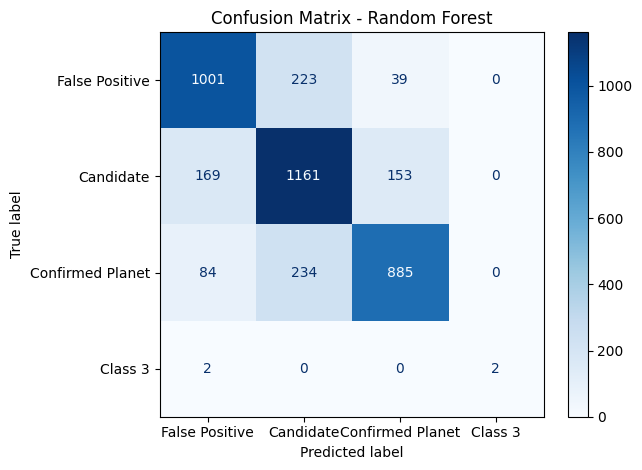

=== FEATURE IMPORTANCE ===
Top 10 Most Important Features:


,feature,importance
9,planet_radius,0.145924
15,lc_time0,0.111727
10,orbital_period,0.092809
2,PC3,0.084537
0,PC1,0.072202
8,kep_mag,0.066346
4,dec,0.061720
3,ra,0.052712
1,PC2,0.050749
11,star_teff,0.050290


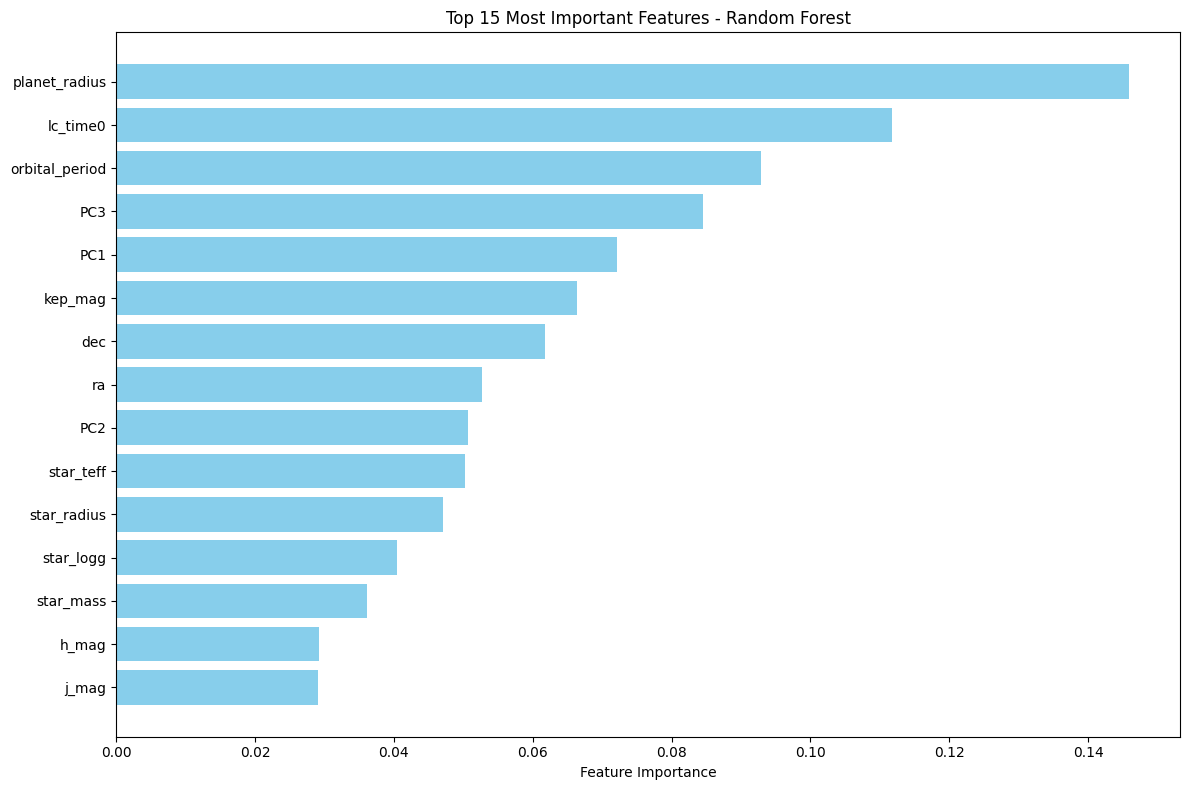

=== PERMUTATION IMPORTANCE ===
Top 10 Features by Permutation Importance:


,feature,importance_mean,importance_std
9,planet_radius,0.120187,0.004270
15,lc_time0,0.086087,0.005034
10,orbital_period,0.071060,0.004273
2,PC3,0.063977,0.002949
8,kep_mag,0.042095,0.002970
0,PC1,0.025626,0.003277
4,dec,0.019099,0.003174
14,star_mass,0.014597,0.001514
13,star_radius,0.012497,0.001821
11,star_teff,0.009107,0.002771


=== HYPERPARAMETER TUNING ===
Performing grid search... (this may take a few minutes)
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Grid search completed!
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.7677
=== FINAL MODEL TRAINING ===
Final Model Test Accuracy: 0.7738
Improvement over initial model: 0.0025
Using tuned model as the best model
Best model accuracy: 0.7738
=== SAVING MODEL ===
Model saved to: ..\model\trained_model.pkl
Scaler saved to: ..\model\preprocessor.pkl
=== MODEL VERIFICATION ===
Test sample true label: 2 (Confirmed Planet)
Loaded model prediction: 2 (Confirmed Planet)
Prediction probabilities: [0.33 0.26 0.41 0.  ]
🎯 MODEL TRAINING SUMMARY

📊 PERFORMANCE METRICS:
   • Best Test Accuracy: 0.7738
   • Cross-validation Mean: 0.7727
   • Weighted Precision: 0.7749
   • Weighted Recall: 0.7713
   • Weighted F1-Score: 0.7718

🔍 KEY INSIGHTS:
   • Most important feat

In [1]:
# %% [markdown]
# # Exoplanet Classification - Model Training
# 
# This notebook trains a Random Forest classifier to predict exoplanet classifications (False Positive, Candidate, Confirmed Planet) based on astrophysical features.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                           confusion_matrix, ConfusionMatrixDisplay, 
                           precision_score, recall_score, f1_score)
from sklearn.inspection import permutation_importance

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# %%
# Load the dataset
data_path = Path('../data/Exoplanet-Dataset.csv')
df = pd.read_csv(data_path)

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")

# %%
# Display basic info about the dataset
print("=== DATASET OVERVIEW ===")
print(f"Features: {df.shape[1] - 1}")  # Excluding target
print(f"Samples: {df.shape[0]}")

# Check for missing values
missing_values = df.isnull().sum().sum()
print(f"Missing values: {missing_values}")

# %%
# Define feature columns and target
feature_columns = ['PC1', 'PC2', 'PC3', 'ra', 'dec', 'j_mag', 'h_mag', 'k_mag', 
                  'kep_mag', 'planet_radius', 'orbital_period', 'star_teff', 
                  'star_logg', 'star_radius', 'star_mass', 'lc_time0']

target_column = 'label'

# Verify all columns exist
missing_features = [col for col in feature_columns if col not in df.columns]
if missing_features:
    print(f"⚠️  Missing features: {missing_features}")
    # Remove missing features from our list
    feature_columns = [col for col in feature_columns if col not in missing_features]

print(f"Using {len(feature_columns)} features for modeling")

# %%
# Prepare features (X) and target (y)
X = df[feature_columns]
y = df[target_column]

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

# %%
# Analyze target distribution
print("=== TARGET DISTRIBUTION ===")
unique_labels = np.unique(y)
label_counts = pd.Series(y).value_counts().sort_index()

# Create label mapping
label_names = {}
for label_val in unique_labels:
    if label_val == 0:
        label_names[label_val] = 'False Positive'
    elif label_val == 1:
        label_names[label_val] = 'Candidate'
    elif label_val == 2:
        label_names[label_val] = 'Confirmed Planet'
    else:
        label_names[label_val] = f'Class {label_val}'

print("Label distribution:")
for label_val, count in label_counts.items():
    percentage = (count / len(y)) * 100
    print(f"  {label_names[label_val]} ({label_val}): {count} samples ({percentage:.1f}%)")

# %%
# Check for class imbalance
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
colors = ['#ff6b6b', '#ffe66d', '#4ecdc4', '#95e1d3'][:len(unique_labels)]
bars = plt.bar([label_names[val] for val in label_counts.index], label_counts.values, color=colors)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.subplot(1, 2, 2)
plt.pie(label_counts.values, labels=[label_names[val] for val in label_counts.index], 
        autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Class Distribution (%)')

plt.tight_layout()
plt.show()

# %%
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Maintain class distribution in splits
)

print("=== DATA SPLITTING ===")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"Training set class distribution:\n{y_train.value_counts().sort_index()}")
print(f"Testing set class distribution:\n{y_test.value_counts().sort_index()}")

# %%
# Feature Scaling
print("=== FEATURE SCALING ===")

scaler = StandardScaler()

# Fit scaler on training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed!")
print(f"Training data shape after scaling: {X_train_scaled.shape}")
print(f"Testing data shape after scaling: {X_test_scaled.shape}")

# %%
# Convert back to DataFrames for better handling (optional)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_columns, index=X_test.index)

# Show scaled feature statistics
print("Scaled training data statistics:")
print(pd.DataFrame(X_train_scaled_df).describe().loc[['mean', 'std']])

# %%
# Initialize Random Forest Classifier
print("=== MODEL TRAINING ===")

# Start with default parameters
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Train the model
rf_model.fit(X_train_scaled_df, y_train)

print("Random Forest model trained successfully!")
print(f"Number of trees: {len(rf_model.estimators_)}")

# %%
# Make predictions on training and testing sets
y_train_pred = rf_model.predict(X_train_scaled_df)
y_test_pred = rf_model.predict(X_test_scaled_df)

# Get prediction probabilities
y_test_proba = rf_model.predict_proba(X_test_scaled_df)

print("Predictions generated!")

# %%
# Model Evaluation
print("=== MODEL EVALUATION ===")

# Calculate accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# %%
# Cross-validation scores
print("=== CROSS-VALIDATION ===")
cv_scores = cross_val_score(rf_model, X_train_scaled_df, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# %%
# Detailed Classification Report
print("=== CLASSIFICATION REPORT (TEST SET) ===")
print(classification_report(y_test, y_test_pred, 
                          target_names=[label_names[i] for i in sorted(unique_labels)]))

# %%
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                            display_labels=[label_names[i] for i in sorted(unique_labels)])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Random Forest')
plt.tight_layout()
plt.show()

# %%
# Feature Importance Analysis
print("=== FEATURE IMPORTANCE ===")

feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
display(feature_importance.head(10))

# %%
# Plot Feature Importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# %%
# Permutation Importance (more robust feature importance)
print("=== PERMUTATION IMPORTANCE ===")

perm_importance = permutation_importance(
    rf_model, X_test_scaled_df, y_test, 
    n_repeats=10, random_state=42, n_jobs=-1
)

perm_importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print("Top 10 Features by Permutation Importance:")
display(perm_importance_df.head(10))

# %%
# Hyperparameter Tuning (Optional - can be skipped if short on time)
print("=== HYPERPARAMETER TUNING ===")

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("Performing grid search... (this may take a few minutes)")

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled_df, y_train)

print("Grid search completed!")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# %%
# Train final model with best parameters
print("=== FINAL MODEL TRAINING ===")

final_model = RandomForestClassifier(
    **grid_search.best_params_,
    random_state=42,
    n_jobs=-1
)

final_model.fit(X_train_scaled_df, y_train)

# Evaluate final model
y_test_pred_final = final_model.predict(X_test_scaled_df)
final_test_accuracy = accuracy_score(y_test, y_test_pred_final)

print(f"Final Model Test Accuracy: {final_test_accuracy:.4f}")

# Compare with initial model
improvement = final_test_accuracy - test_accuracy
print(f"Improvement over initial model: {improvement:.4f}")

# %%
# Use the best model (either tuned or initial)
if final_test_accuracy > test_accuracy:
    best_model = final_model
    best_accuracy = final_test_accuracy
    print("Using tuned model as the best model")
else:
    best_model = rf_model
    best_accuracy = test_accuracy
    print("Using initial model as the best model")

print(f"Best model accuracy: {best_accuracy:.4f}")

# %%
# Model Persistence - Save the trained model and scaler
print("=== SAVING MODEL ===")

# Create model directory if it doesn't exist
model_dir = Path('../model')
model_dir.mkdir(exist_ok=True)

# Save the best model
model_path = model_dir / 'trained_model.pkl'
joblib.dump(best_model, model_path)

# Save the scaler
scaler_path = model_dir / 'preprocessor.pkl'
joblib.dump(scaler, scaler_path)

print(f"Model saved to: {model_path}")
print(f"Scaler saved to: {scaler_path}")

# %%
# Verify that the model can be loaded and used
print("=== MODEL VERIFICATION ===")

# Load the saved model and scaler
loaded_model = joblib.load(model_path)
loaded_scaler = joblib.load(scaler_path)

# Test prediction with loaded model
test_sample = X_test_scaled_df.iloc[0:1]  # First test sample
loaded_prediction = loaded_model.predict(test_sample)
loaded_probability = loaded_model.predict_proba(test_sample)

print(f"Test sample true label: {y_test.iloc[0]} ({label_names[y_test.iloc[0]]})")
print(f"Loaded model prediction: {loaded_prediction[0]} ({label_names[loaded_prediction[0]]})")
print(f"Prediction probabilities: {loaded_probability[0]}")

# %%
# Model Performance Summary
print("="*60)
print("🎯 MODEL TRAINING SUMMARY")
print("="*60)

print(f"\n📊 PERFORMANCE METRICS:")
print(f"   • Best Test Accuracy: {best_accuracy:.4f}")
print(f"   • Cross-validation Mean: {cv_scores.mean():.4f}")

# Calculate additional metrics
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"   • Weighted Precision: {precision:.4f}")
print(f"   • Weighted Recall: {recall:.4f}")
print(f"   • Weighted F1-Score: {f1:.4f}")

print(f"\n🔍 KEY INSIGHTS:")
print(f"   • Most important feature: {feature_importance.iloc[0]['feature']} "
      f"(importance: {feature_importance.iloc[0]['importance']:.4f})")
print(f"   • Number of features used: {len(feature_columns)}")
print(f"   • Classes: {list(label_names.values())}")

print(f"\n💾 MODEL FILES:")
print(f"   • Model: {model_path}")
print(f"   • Scaler: {scaler_path}")

print(f"\n✅ MODEL TRAINING COMPLETED SUCCESSFULLY!")
print("The model is ready for use in the FastAPI application.")

# %%
# Additional: Create a sample prediction function for demonstration
def predict_exoplanet(features_dict, model=best_model, scaler=scaler, feature_names=feature_columns):
    """
    Predict exoplanet classification for a single sample
    """
    # Convert input to DataFrame
    input_df = pd.DataFrame([features_dict])[feature_names]
    
    # Scale features
    input_scaled = scaler.transform(input_df)
    
    # Make prediction
    prediction = model.predict(input_scaled)[0]
    probabilities = model.predict_proba(input_scaled)[0]
    
    return {
        'prediction': int(prediction),
        'class_name': label_names[prediction],
        'probabilities': {
            label_names[i]: float(prob) for i, prob in enumerate(probabilities)
        },
        'confidence': float(max(probabilities))
    }

# Test the prediction function with sample data
print("=== SAMPLE PREDICTION ===")
sample_features = {
    'PC1': -0.329993,
    'PC2': -0.469118,
    'PC3': -0.051703,
    'ra': 297.00482,
    'dec': 48.134129,
    'j_mag': 14.254,
    'h_mag': 13.9,
    'k_mag': 13.826,
    'kep_mag': 15.436,
    'planet_radius': 14.6,
    'orbital_period': 19.89914,
    'star_teff': 5853.0,
    'star_logg': 4.544,
    'star_radius': 0.868,
    'star_mass': 0.961,
    'lc_time0': 175.850252
}

sample_prediction = predict_exoplanet(sample_features)
print("Sample prediction result:")
for key, value in sample_prediction.items():
    print(f"  {key}: {value}")